In [57]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import pandas as pd

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers.legacy import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.13.0


In [58]:
#Load dataset

data_path = "dataset/"
emotions = os.listdir(data_path)

# Check for '.DS_Store' and delete it
if '.DS_Store' in emotions:
    os.remove(os.path.join(data_path, '.DS_Store'))
    emotions.remove('.DS_Store')

print(emotions)

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']


dataset/happy
dataset/sad
dataset/fear
dataset/surprise
dataset/neutral
dataset/angry
dataset/disgust


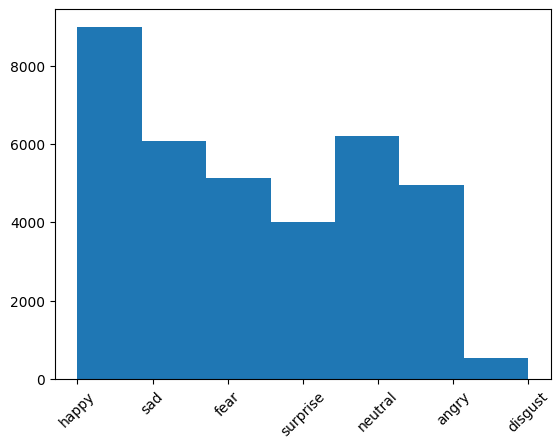

In [59]:
img_size = 48 #By default, the images in FER2013 dataset is in 48x48

data = []
labels = []

# Looping through subfolders in the data path
for emotion in emotions:
    emotion_folder = os.path.join(data_path, emotion)
    print(emotion_folder)
    if not os.path.isdir(emotion_folder):
        continue
    for img in os.listdir(emotion_folder):
        img_path = os.path.join(emotion_folder, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            data.append(img)
            labels.append(emotions.index(emotion))

# Convert image data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Plot the distribution of the labels, bar graph
plt.hist(labels, bins=len(emotions))
plt.xticks(range(len(emotions)), emotions, rotation=45)
plt.show()

In [60]:
from sklearn.utils.class_weight import compute_sample_weight

# Load the images and their labels
image_dir = "./dataset/"
labels = []
images = []
for folder in os.listdir(image_dir):
    for file in os.listdir(os.path.join(image_dir, folder)):
        if file.endswith(".jpg"):
            images.append(img_to_array(load_img(os.path.join(image_dir, folder, file), color_mode="grayscale")))
            labels.append(folder)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images = images / 255.0

# One-hot encode the labels
label_dict = {label: i for i, label in enumerate(np.unique(labels))}
labels = to_categorical(np.vectorize(label_dict.get)(labels))

# Convert one-hot encoded labels back to their original form
original_labels = np.argmax(labels, axis=1)

# Define the mapping
emotion_to_vac = {
    'Happy': [0.8, 0.8],
    'Angry': [-0.8, 0.8],
    'Surprise': [0.8, 0.8],
    'Fear': [-0.8, 0.8],
    'Sad': [-0.8, -0.8],
    'Disgust': [-0.8, 0.8],
    'Neutral': [0.0, 0.0]
}

# Define class_names, to be used for CM
class_names = list(emotion_to_vac.keys())

# Reverse the label_dict
reverse_label_dict = {v: k for k, v in label_dict.items()}

# Convert integer labels back to emotion names and capitalize them
emotion_labels = [reverse_label_dict[label].capitalize() for label in original_labels]

# Transform your labels into Valence-Arousal coordinates
vac_labels = np.array([emotion_to_vac[emotion] for emotion in emotion_labels])

# Transform your labels into Valence-Arousal coordinates
vac_labels = np.array([emotion_to_vac[emotion] for emotion in emotion_labels])

# Compute class weights
class_weights = compute_sample_weight(class_weight='balanced', y=original_labels)
n_samples = len(original_labels)
n_classes = len(np.unique(original_labels))
counts = np.bincount(original_labels)
class_weights = n_samples / (n_classes * counts)

# Split the data into training and testing sets
train_images, test_images, train_vac_labels, test_vac_labels = train_test_split(images, vac_labels, test_size=0.3, stratify=original_labels, random_state=42)


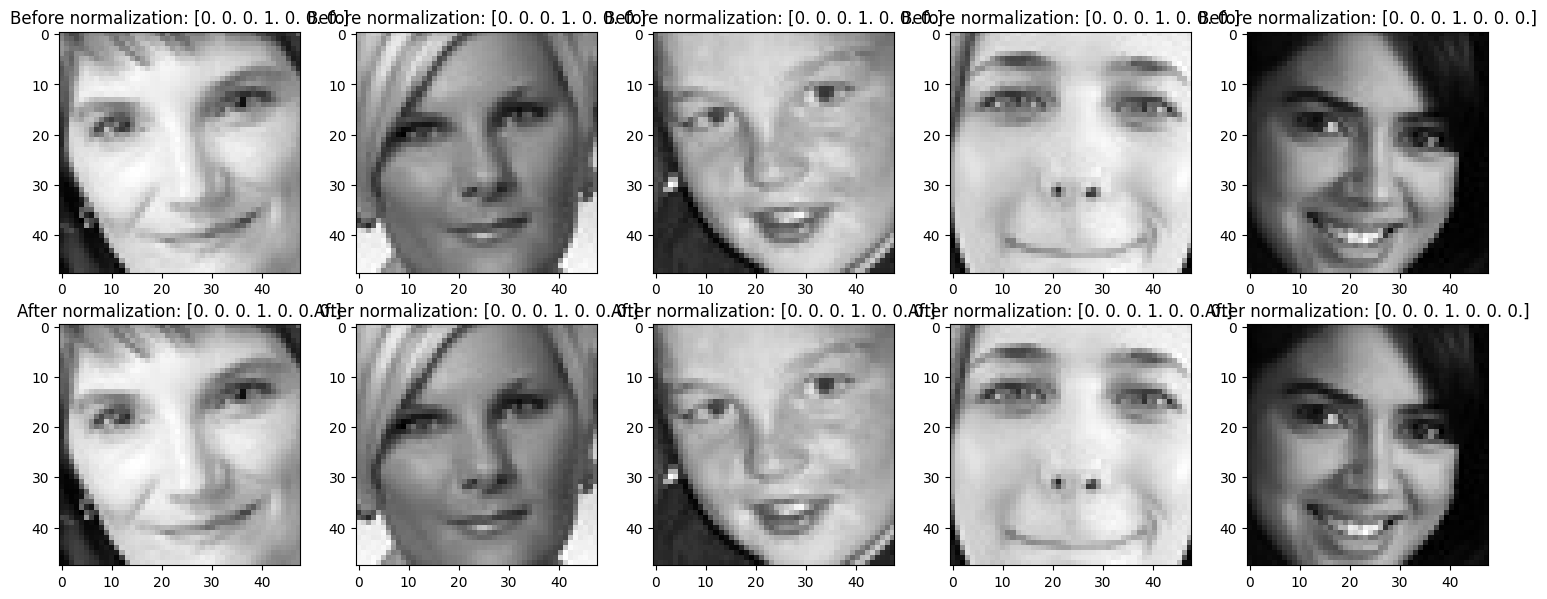

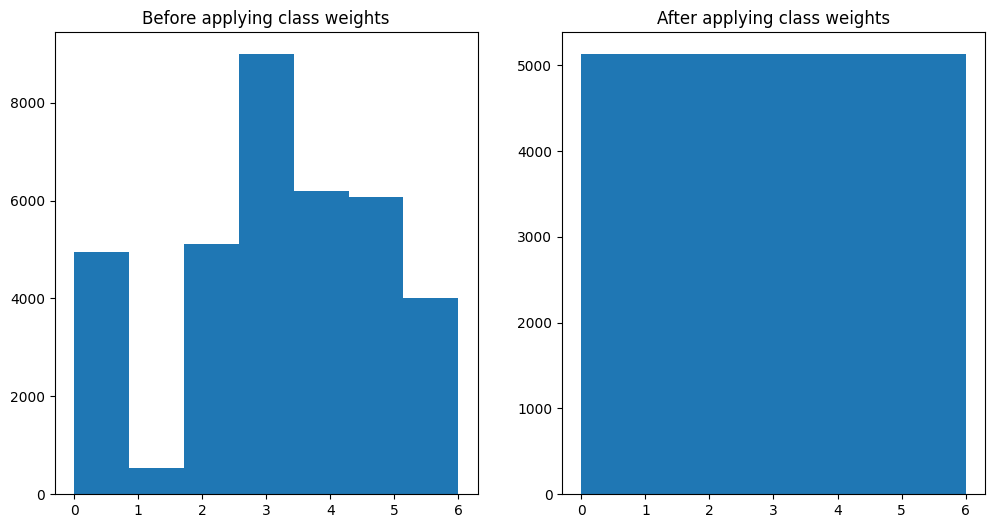

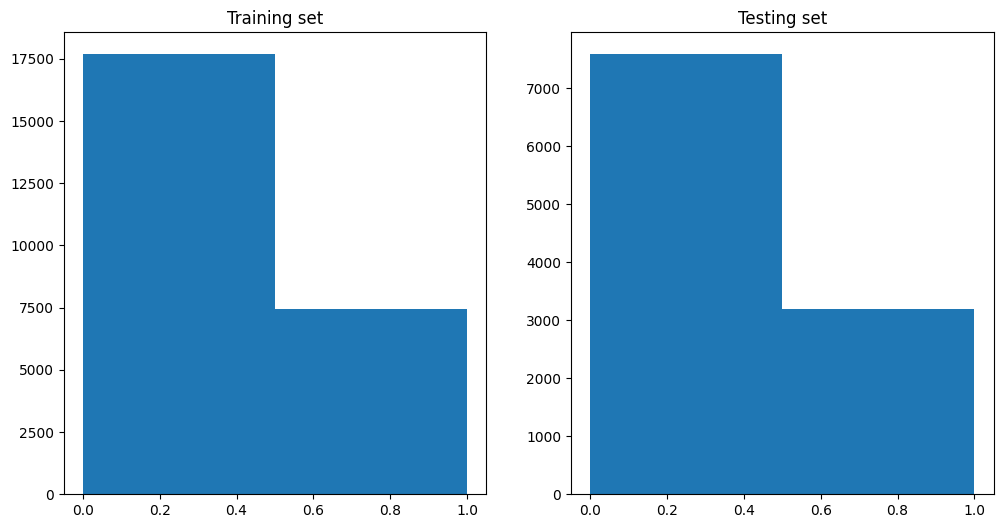

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize some images before and after normalization
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Before normalization
    axs[0, i].imshow(images[i] * 255, cmap='gray')
    axs[0, i].set_title(f'Before normalization: {labels[i]}')
    # After normalization
    axs[1, i].imshow(images[i], cmap='gray')
    axs[1, i].set_title(f'After normalization: {labels[i]}')
plt.tight_layout()
plt.show()

# Create an array of class weights for each sample
sample_weights = class_weights[original_labels]

# Plot the distribution of your labels before and after applying class weights
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(original_labels, bins=n_classes)
axs[0].set_title('Before applying class weights')
axs[1].hist(original_labels, weights=sample_weights, bins=n_classes)
axs[1].set_title('After applying class weights')
plt.show()

# Find the number of unique classes in your labels
n_classes = len(np.unique(np.concatenate((np.argmax(train_vac_labels, axis=1), np.argmax(test_vac_labels, axis=1)))))

# Visualize the distribution of your data after splitting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(np.argmax(train_vac_labels, axis=1), bins=n_classes)
axs[0].set_title('Training set')
axs[1].hist(np.argmax(test_vac_labels, axis=1), bins=n_classes)
axs[1].set_title('Testing set')
plt.show()

In [62]:
from keras.regularizers import l2

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1), kernel_regularizer=l2(0.01)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(2)  # 2 outputs for the valence and arousal
])

model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])

In [76]:
def display_samples(images, labels, predictions, class_names):
    # Get the unique labels
    unique_labels = np.unique(labels)

    # For each unique label
    for label in unique_labels:
        # Get the indices of images with this label
        indices = np.where(labels == label)[0]

        # Choose one random index
        sample_index = np.random.choice(indices, 1)

        # Get the sample image and its corresponding prediction
        sample_image = images[sample_index]
        sample_prediction = predictions[sample_index]

        # Display the sample image with the predicted valence and arousal rates
        plt.imshow(sample_image[0])
        # Get the emotion name from the class_names
        emotion_name = class_names[int(label)]
        plt.text(sample_image[0].shape[1] - 20, sample_image[0].shape[0] - 10, 
                 f'Emotion: {emotion_name}, Valence: {sample_prediction[0, 0]:.2f}, Arousal: {sample_prediction[0, 1]:.2f}', 
                 color='red')
        plt.show()
        print(emotion_name)

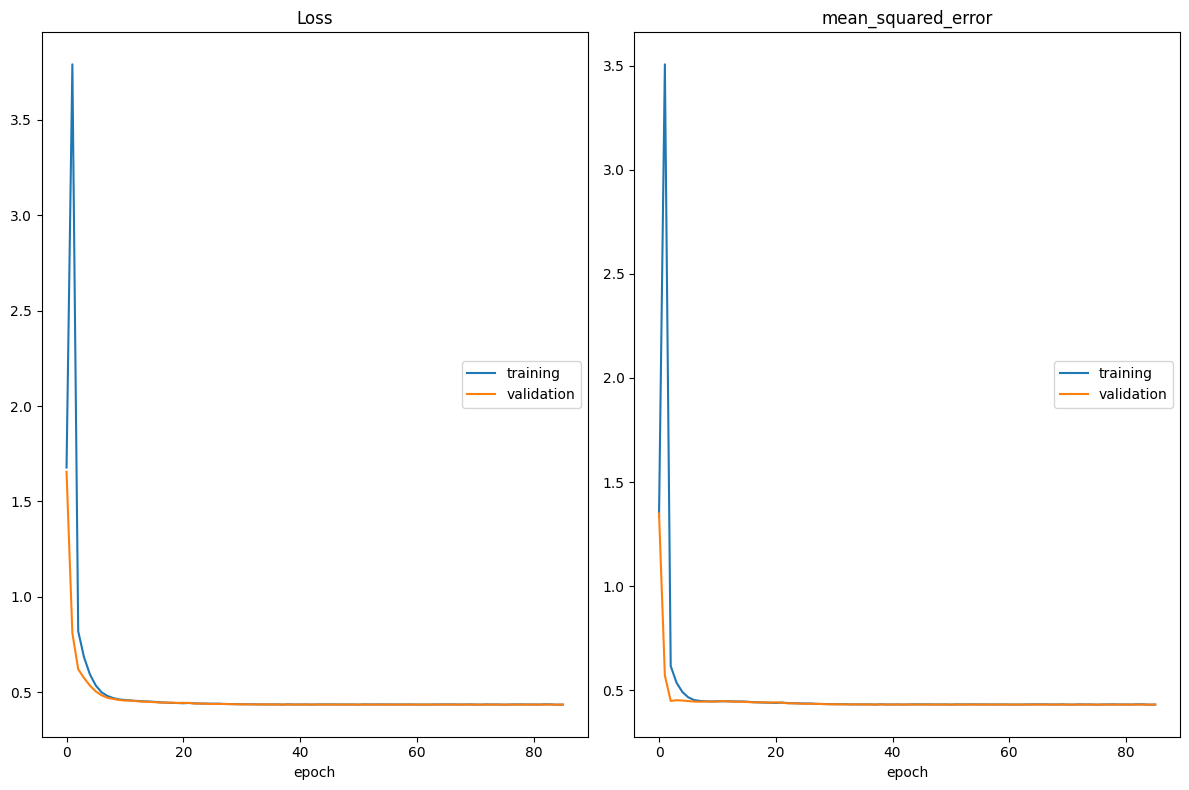

Loss
	training         	 (min:    0.435, max:    3.790, cur:    0.436)
	validation       	 (min:    0.436, max:    1.656, cur:    0.436)
mean_squared_error
	training         	 (min:    0.431, max:    3.506, cur:    0.431)
	validation       	 (min:    0.431, max:    1.349, cur:    0.431)

Epoch 86: saving model to model_weights.h5
Restoring model weights from the end of the best epoch: 76.
785/785 [==============================] - 26s 33ms/step - loss: 0.4357 - mean_squared_error: 0.4312 - val_loss: 0.4357 - val_mean_squared_error: 0.4312 - lr: 1.0000e-05
Epoch 86: early stopping
 62/337 [====>.........................] - ETA: 0s

2023-12-25 20:21:36.511047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


337/337 [==============================] - 1s 3ms/step


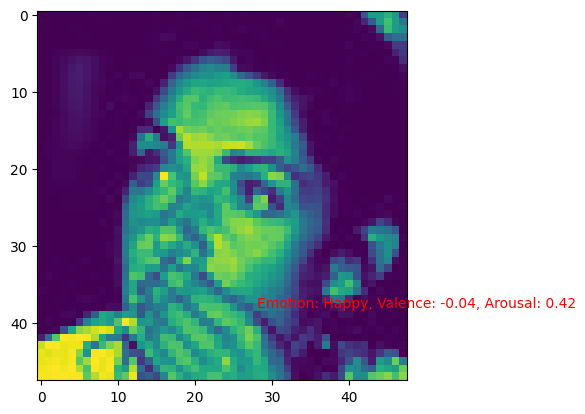

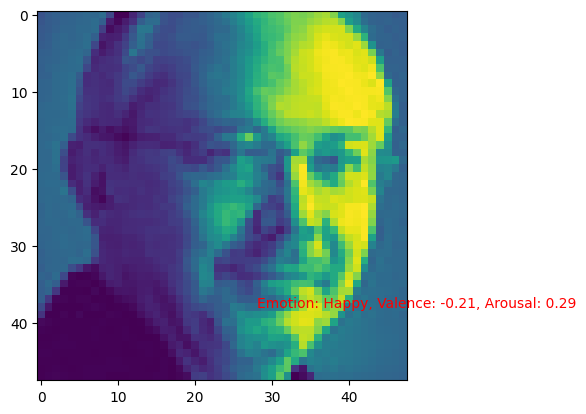

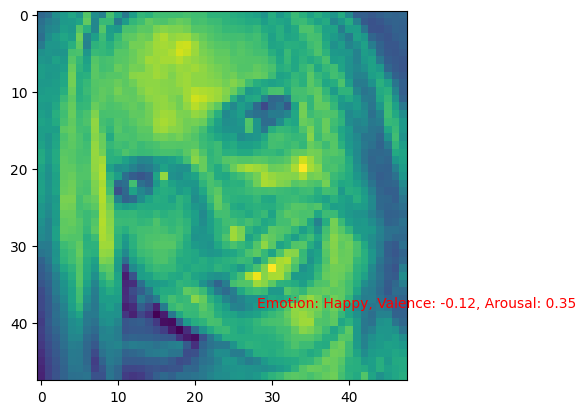

In [69]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import CSVLogger, TensorBoard
from keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_loss',
                             save_weights_only=True, mode='min', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, model='auto')
csv_logger = CSVLogger('training.log')

tensorboard = TensorBoard(log_dir='./result', histogram_freq=0, write_graph=True, write_images=False)

# Use this callback in your model.fit call
callbacks= [PlotLossesKeras(), checkpoint, reduce_lr, csv_logger, tensorboard]
# Train the model without the ScatterPlotCallback.
model.fit(train_images,
          train_vac_labels,
          batch_size=32,
          epochs=100,
          verbose=1,
          validation_data=(test_images, test_vac_labels),
          callbacks=callbacks+[early_stopping])

# Predict the valence-arousal coordinates for the test images
predictions = model.predict(test_images)

# Display 1 sample image from each emotion
display_samples(test_images, test_vac_labels, predictions, class_names)


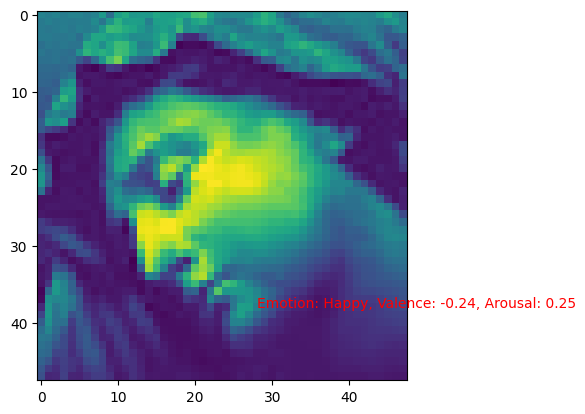

p


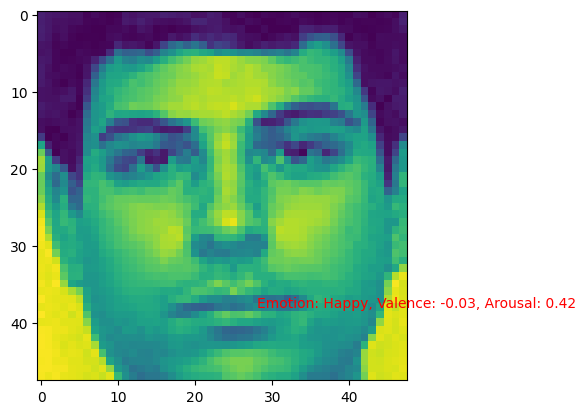

p


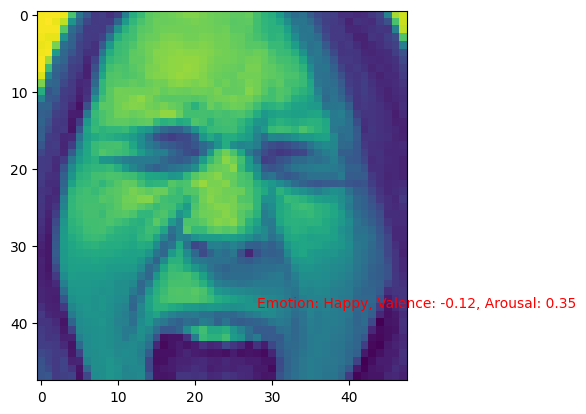

p


In [81]:
# Display 1 sample image from each emotion
display_samples(test_images, test_vac_labels, predictions, class_names)

In [83]:
# Save the model architecture to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save model's weights
model.save_weights("model_weights.h5")

# Save entire model
model.save("model.h5")

/Users/riaacordero/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


337/337 [==============================] - 2s 5ms/step


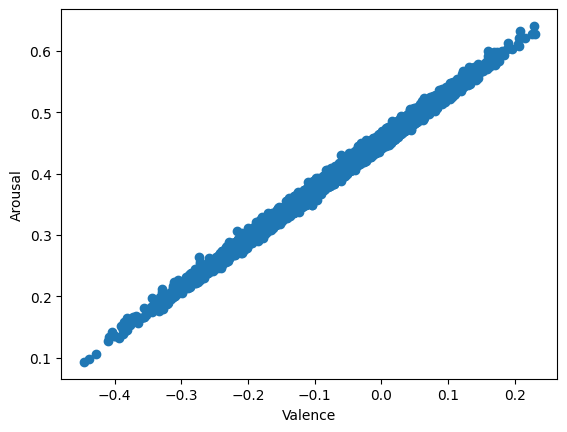

In [82]:
import matplotlib.pyplot as plt

# Predict the valence-arousal coordinates for the test images
predictions = model.predict(test_images)

# Plot the predicted valence-arousal coordinates
plt.scatter(predictions[:, 0], predictions[:, 1])
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.show()